In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from prettytable import PrettyTable
import pySBA
import os

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams["figure.autolayout"] = True

In [2]:
tmp_local_root = "C:/Users/ilow1/Documents/code/bird_pose_tracking/"
root_dir = f"{tmp_local_root}calibration_files/"

In [3]:
# camera params
cam_ids = ['red_cam', 'yellow_cam', 'green_cam', 'blue_cam']
# cam_ids = ['rBack', 'rFront', 'rTop', 'lBack', 'lFront', 'lTop'] # SC cam IDs
# cam_ids = ['rBack', 'rFront', 'lBack', 'lFront'] # SC cam IDs top excluded
n_cams = len(cam_ids)

# path to camera array file
file_path = 'C:/Users/ilow1/Documents/code/bird_pose_tracking/calibration_files/'
cam_array_folder = 'init_cam_arrays/' # to load initial estimates
    
# load camera data for pySBA - initial estimates
# cam_array, cam_array_fields = pySBA.getCameraArray(f'{file_path}{cam_array_folder}', camera_ids=cam_ids)
# cam_array, cam_array_fields = pySBA.getCameraArray_SC(cam_ids) # SC initial est

# load camera data for pySBA - saved file
opt_array_file = '240716_opt_cam_array_zeroes_init.npy'
cam_array, cam_array_fields = pySBA.getCameraArray(file_path, camera_ids=cam_ids,
                                                   load_opt_array=True, opt_file_name=opt_array_file)

In [4]:
''' First, optimize the camera extrinsics using points with known 3D coordinates '''
calib_pt_folder = "known_points/"
img_date = input("input date of image acquisition (YYMMDD): ")
save_dir = f"{tmp_local_root}figures/camera_calibration_figs/{img_date}/"
if os.path.exists(save_dir):
    print("warning, save folder already exists!")
else:
    os.mkdir(save_dir)

# load the set of 3D points w/ known world coordinates
pts_3d_known = np.load(f'{root_dir}{calib_pt_folder}points_3d_simple.npy')

# load the corresponding 2D points (hand labeled for each camera)
pts_2d_known = np.load(f'{root_dir}{calib_pt_folder}{img_date}_points_2d.npy')
n_pts = pts_2d_known.shape[0]

# load the camera and point indexing variables
known_pts_camera_idx = np.load(f'{root_dir}{calib_pt_folder}{img_date}_camera_ind.npy')
known_pts_idx = np.load(f'{root_dir}{calib_pt_folder}{img_date}_point_ind.npy')
known_pts_camera_idx = np.squeeze(known_pts_camera_idx.astype(int))
known_pts_idx = np.squeeze(known_pts_idx.astype(int))

input date of image acquisition (YYMMDD): 240719


In [5]:
# display the initial camera params
sba = pySBA.PySBA(cam_array, pts_3d_known, pts_2d_known, 
                  known_pts_camera_idx, known_pts_idx)
# sba = pySBA.PySBA(opt_cam_array, pts_3d_known, pts_2d_known, 
#                   known_pts_camera_idx, known_pts_idx)
# display the initial camera params
x = PrettyTable()
x.field_names = cam_array_fields
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.82 |  2.09 |  -1.5 |  -0.05  |  -0.12  |   2.33  |  1852.83   |    -0.2   |    0.15   | 936.7  | 475.92 |
|  0.86 | -2.02 |  1.51 |  -0.08  |  -0.13  |   2.28  |  1852.83   |    -0.2   |    0.15   | 952.32 | 497.79 |
|  1.7  | -0.76 |  0.56 |   0.04  |  -0.13  |   2.38  |  1852.83   |    -0.2   |    0.15   | 942.29 | 499.12 |
|  1.77 |  0.73 | -0.52 |  -0.08  |  -0.18  |   2.32  |  1852.83   |    -0.2   |    0.15   | 981.12 | 501.49 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


C:\Users\ilow1\AppData\Local\Temp\ipykernel_2228\3976245522.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{save_dir}init_pts_3d.png', dpi=600, bbox_inches='tight')
C:\Users\ilow1\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


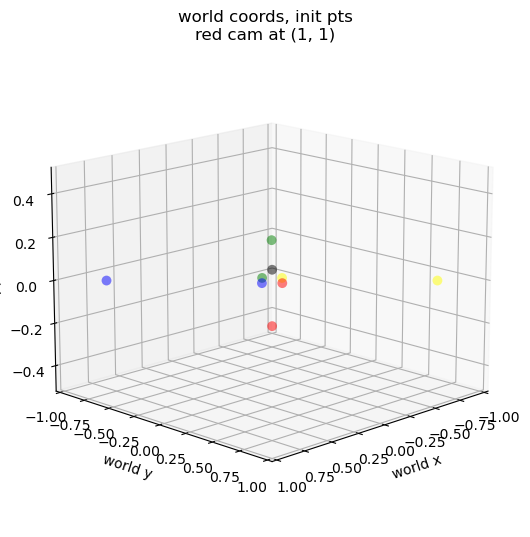

In [6]:
# plot the point locations to double check them
colors = ['black', 'red', 'yellow', 'green', 'blue', 
          'red', 'yellow', 'green', 'blue']

# plot the points in 3D
fig = plt.figure(figsize=(8, 4))
ax = plt.axes([0, 0, .6, 1.2], projection='3d')

x_pts = pts_3d_known[:, 0].copy()
y_pts = pts_3d_known[:, 1].copy()
z_pts = pts_3d_known[:, 2].copy()

ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors, alpha=0.5, lw=0, s=50)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-0.5, 0.5)

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=45, elev=15)
ax.set_title(f'world coords, init pts\nred cam at (1, 1)')

fig.savefig(f'{save_dir}init_pts_3d.png', dpi=600, bbox_inches='tight')
plt.show()

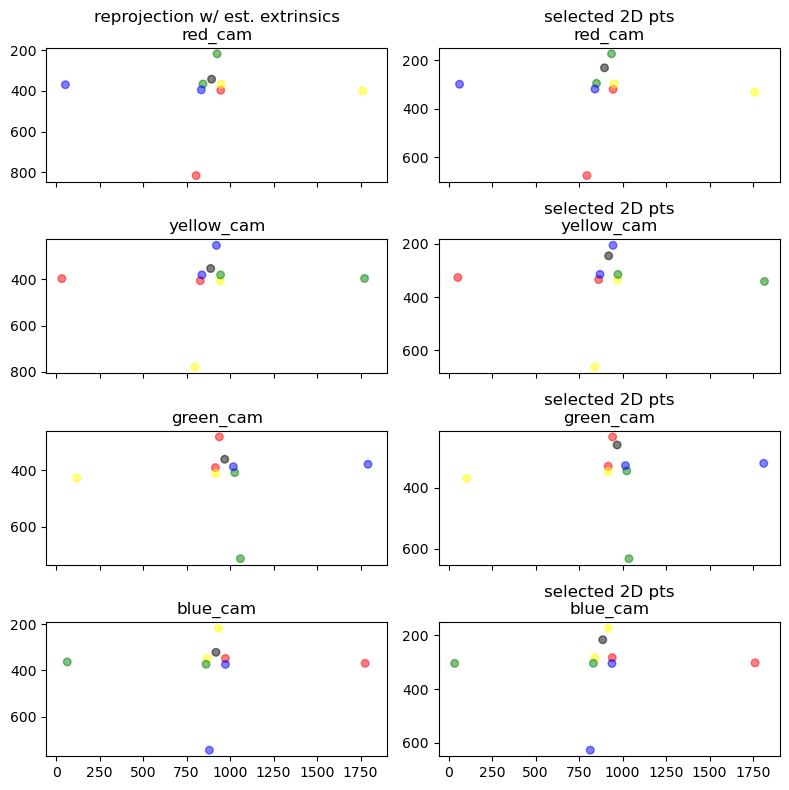

In [7]:
# get reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))

# selected points
for i in range(n_cams):
    cam_idx = known_pts_camera_idx==i
    axs[i, 1].scatter(pts_2d_known[cam_idx, 0],
                   pts_2d_known[cam_idx, 1],
                   c=colors, alpha=0.5, s=30)
    axs[i, 1].title.set_text(f'selected 2D pts\n{cam_ids[i]}')
    axs[i, 1].invert_yaxis()
    
# reprojected points, original extrinsics
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    axs[i, 0].scatter(est_pts[ind2d, 0],\
                    est_pts[ind2d, 1],\
                    s=30, c=colors, alpha=0.5)
    if i == 0:
        axs[i, 0].title.set_text(f'reprojection w/ est. extrinsics\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')    
    axs[i, 0].invert_yaxis()

        
plt.show()
fig.savefig(f'{save_dir}init_pts_2d.png', dpi=600, bbox_inches='tight')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1710e+05                                    6.55e+05    
       1              2         2.7840e+03      1.14e+05       2.00e-01       1.38e+04    
       2              3         2.7452e+03      3.88e+01       3.85e-03       5.09e+00    
       3              4         2.7452e+03      1.39e-04       3.08e-05       1.49e-01    
       4              5         2.7452e+03      1.66e-08       2.48e-07       1.65e-02    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.1710e+05, final cost 2.7452e+03, first-order optimality 1.65e-02.


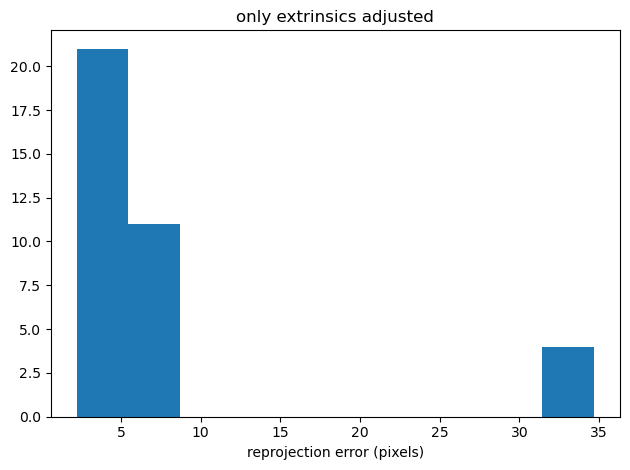

In [8]:
# optimize the camera extrinsics, holding the intrinsics fixed, using known 3D points
sba.bundleAdjust_just_extrinsics()

# plot the reprojection error
r = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices]) - sba.points2D
r = np.sqrt(np.sum(r**2, axis=1))

fig, ax = plt.subplots(1, 1)
ax.hist(r)
ax.set_xlabel('reprojection error (pixels)')
ax.set_title('only extrinsics adjusted')
plt.show()
fig.savefig(f'{save_dir}reproj_error_step1.png', dpi=600, bbox_inches='tight')

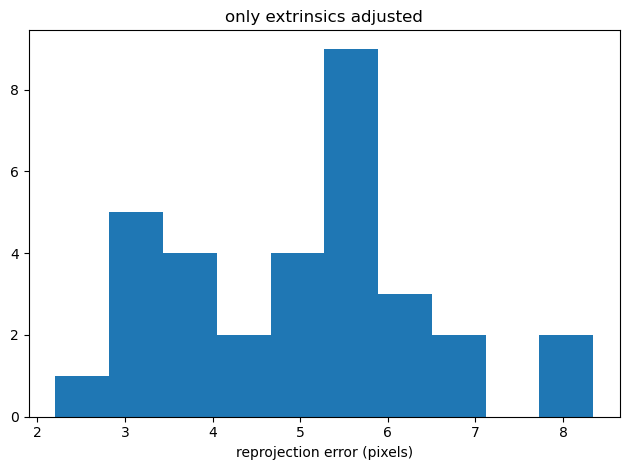

In [9]:
fig, ax = plt.subplots(1, 1)
ax.hist(r[r < 20])
ax.set_xlabel('reprojection error (pixels)')
ax.set_title('only extrinsics adjusted')
plt.show()
fig.savefig(f'{save_dir}reproj_error_step1.png', dpi=600, bbox_inches='tight')

In [10]:
# display the updated camera params
x = PrettyTable()
x.field_names = cam_array_fields.copy()
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.1  | -1.51 |  -0.05  |  -0.22  |   2.34  |  1852.83   |    -0.2   |    0.15   | 936.7  | 475.92 |
|  0.87 | -2.02 |  1.51 |  -0.04  |  -0.21  |   2.24  |  1852.83   |    -0.2   |    0.15   | 952.32 | 497.79 |
|  1.71 | -0.75 |  0.54 |   0.03  |  -0.21  |   2.32  |  1852.83   |    -0.2   |    0.15   | 942.29 | 499.12 |
|  1.78 |  0.73 | -0.53 |  -0.12  |  -0.26  |   2.3   |  1852.83   |    -0.2   |    0.15   | 981.12 | 501.49 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


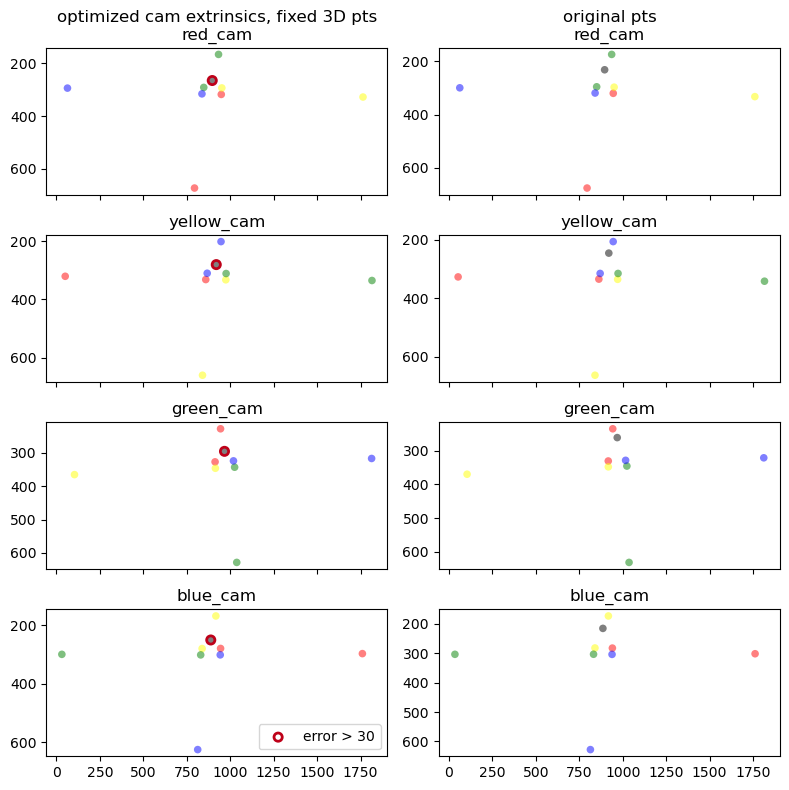

In [11]:
''' compare the reprojected 2D points to the original points - highlight points w/ high error '''
# get reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))
r_thresh = 30

# reprojected points, optimized extrinsics
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    cam_points = est_pts[ind2d].squeeze()
    axs[i, 0].scatter(cam_points[:, 0],\
                    cam_points[:, 1],\
                    s=30, lw=0, c=colors, alpha=0.5)
    # highlight error
    pts_error = r[ind2d]
    axs[i, 0].scatter(cam_points[pts_error > r_thresh, 0],\
                    cam_points[pts_error > r_thresh, 1],\
                    facecolors='none', edgecolors='xkcd:scarlet', 
                    s=35, lw=2, alpha=1, label=f'error > {r_thresh}')
    
    if i == 0:
        axs[i, 0].title.set_text(f'optimized cam extrinsics, fixed 3D pts\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')   
    if i == (n_cams-1):
        axs[i, 0].legend(loc='lower right')
    axs[i, 0].invert_yaxis()

# orginal points
for i in range(n_cams):
    cam_idx = known_pts_camera_idx==i
    axs[i, 1].scatter(pts_2d_known[cam_idx, 0],
                      pts_2d_known[cam_idx, 1],
                      s=30, lw=0, c=colors, alpha=0.5)
    if i == 0:
        axs[i, 1].title.set_text(f'original pts\n{cam_ids[i]}')
    else:
        axs[i, 1].title.set_text(f'{cam_ids[i]}')
    axs[i, 1].invert_yaxis()
    
fig.savefig(f'{save_dir}known_3d_pts.png', dpi=600, bbox_inches='tight')
plt.show()

In [12]:
# save the updated camera array
cam_array_new = sba.cameraArray

In [13]:
''' Given the updated camera extrinsics, optimize the 3D world coordinates of the laser points '''
# make a folder for saving figures
img_date = input("input date of calibration image acquisition (YYMMDD): ")
save_dir = f"{tmp_local_root}figures/camera_calibration_figs/{img_date}/"
if os.path.exists(save_dir):
    print("warning, save folder already exists!")
else:
    os.mkdir(save_dir)
        
# load the preprocessed centroid locations and indices
centroid_dir = f"{tmp_local_root}calibration_files/preprocessed_centroids/"

file_centroids = f'{img_date}_centroids.npy'
points_2d = np.load(f'{centroid_dir}{file_centroids}')

file_camera_ind = f'{img_date}_camera_ind.npy'
camera_ind = np.load(f'{centroid_dir}{file_camera_ind}')

file_point_ind = f'{img_date}_point_ind.npy'
point_ind = np.load(f'{centroid_dir}{file_point_ind}')

input date of calibration image acquisition (YYMMDD): 240716
warning, save folder already exists!


In [14]:
# data params
n_pts = np.max(point_ind) + 1
print(f'analyzing {n_pts} centroids')

# initialize the 3D points as an array of zeros
# may change this...see extract_preprocess_centroids.ipynb
points_3d = np.zeros(shape=(n_pts, 3))

analyzing 24757 centroids


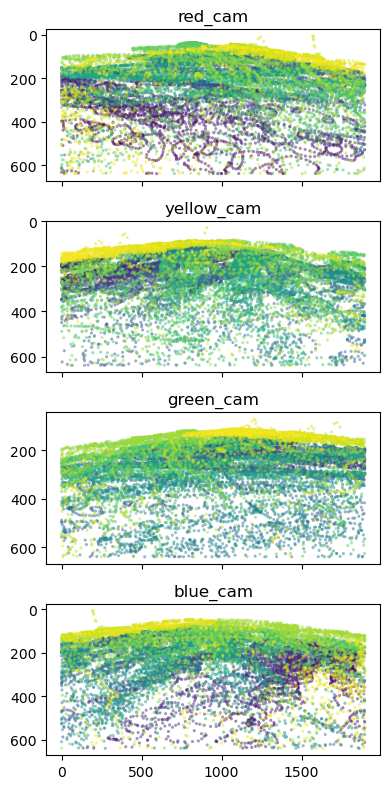

In [15]:
# plot the 2D points for each camera
fig, axs = plt.subplots(n_cams, 1, sharex=True, figsize=(4, 8))

for i in range(n_cams):
    # data params
    ind2d = camera_ind==i
    cam_points = points_2d[ind2d].squeeze()
    n_pts = cam_points.shape[0]
    
    # plot the points
    colors = np.linspace(0, 1, n_pts)
    axs[i].scatter(cam_points[:, 0],
                   cam_points[:, 1],
                   s=5, lw=0, c=colors, alpha=0.5)
    axs[i].invert_yaxis()
    axs[i].title.set_text(f'{cam_ids[i]}') 

plt.show()
fig.savefig(f'{save_dir}original_pts.png', dpi=600, bbox_inches='tight')

In [16]:
sba = pySBA.PySBA(cam_array_new, points_3d, points_2d, camera_ind, point_ind)

# display the initial camera params
x = PrettyTable()
x.field_names = cam_array_fields
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.1  | -1.51 |  -0.05  |  -0.22  |   2.34  |  1852.83   |    -0.2   |    0.15   | 936.7  | 475.92 |
|  0.87 | -2.02 |  1.51 |  -0.04  |  -0.21  |   2.24  |  1852.83   |    -0.2   |    0.15   | 952.32 | 497.79 |
|  1.71 | -0.75 |  0.54 |   0.03  |  -0.21  |   2.32  |  1852.83   |    -0.2   |    0.15   | 942.29 | 499.12 |
|  1.78 |  0.73 | -0.53 |  -0.12  |  -0.26  |   2.3   |  1852.83   |    -0.2   |    0.15   | 981.12 | 501.49 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2692e+09                                    1.73e+06    
       1              2         8.2691e+09      1.27e+05       1.03e-03       1.73e+06    
       2              3         8.2688e+09      2.54e+05       2.06e-03       1.73e+06    
       3              4         8.2683e+09      5.08e+05       4.12e-03       1.73e+06    
       4              5         8.2673e+09      1.02e+06       8.24e-03       1.73e+06    
       5              6         8.2653e+09      2.03e+06       1.65e-02       1.73e+06    
       6              7         8.2612e+09      4.07e+06       3.29e-02       1.73e+06    
       7              8         8.2531e+09      8.13e+06       6.59e-02       1.72e+06    
       8              9         8.2368e+09      1.62e+07       1.32e-01       1.72e+06    
       9             10         8.2044e+09      3.24e+07       2.63e-01       1.72e+06    

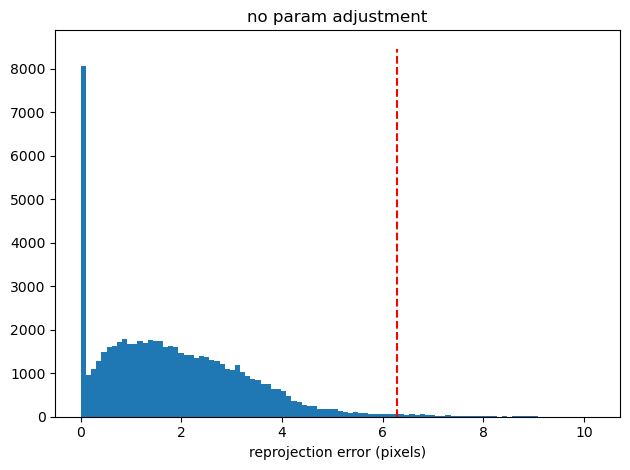

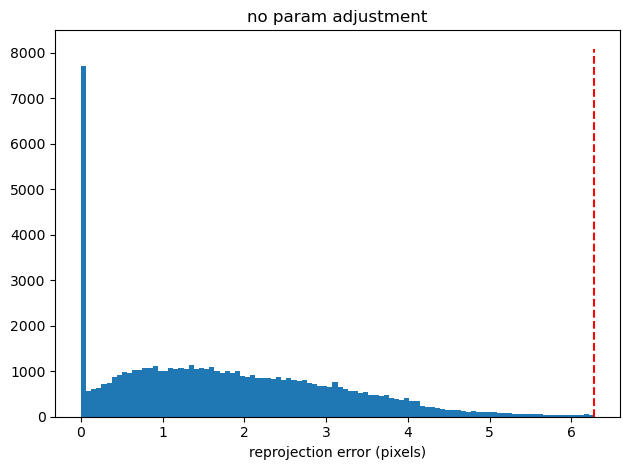

In [17]:
"""
Optimize for the 3d positions holding all camera parameters fixed
"""
sba.bundleAdjust_nocam()

# get the reprojection error
r = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices]) - sba.points2D
r = np.sqrt(np.sum(r**2, axis=1))

# error threshold for "high" pixel error
r_thresh = np.percentile(r, 99)

# plot the reprojection error
fig, ax = plt.subplots(1, 1)
ax.hist(r, bins=100)
ymin, ymax = ax.get_ylim()
ax.vlines(r_thresh, ymin, ymax, colors='red', linestyles='dashed')
ax.set_xlabel('reprojection error (pixels)')
ax.set_title('no param adjustment')
plt.show()
fig.savefig(f'{save_dir}reproj_error_step2.png', dpi=600, bbox_inches='tight')

# plot the reprojection error (zoom)
fig, ax = plt.subplots(1, 1)
ax.hist(r[r < np.percentile(r, 99)], bins=100)
ymin, ymax = ax.get_ylim()
ax.vlines(r_thresh, ymin, ymax, colors='red', linestyles='dashed')
ax.set_xlabel('reprojection error (pixels)')
ax.set_title('no param adjustment')
plt.show()

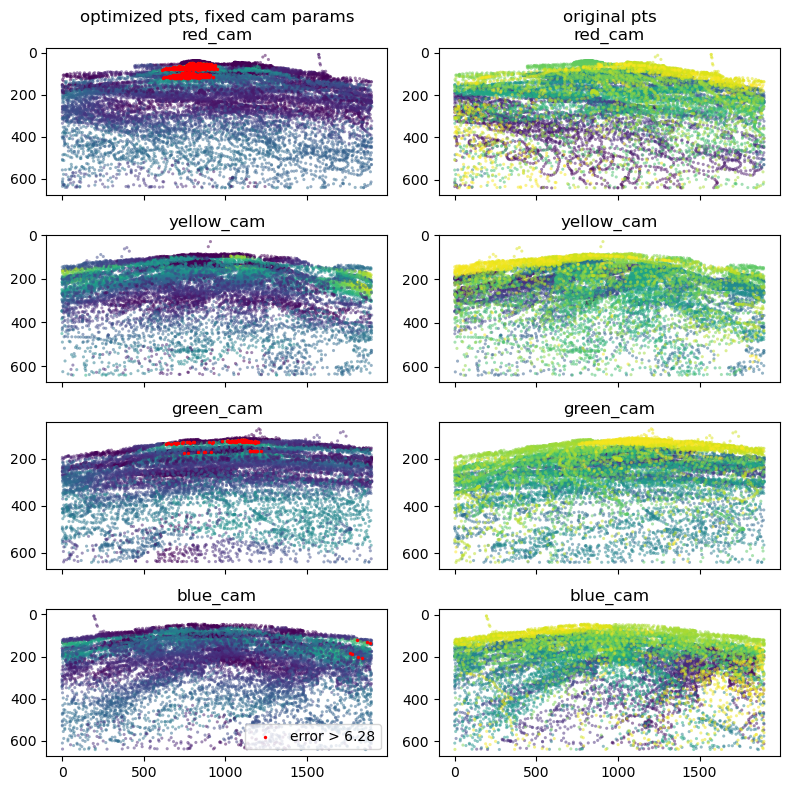

In [18]:
''' compare the reprojected 2D points to the original points '''
# get reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))

# reprojected points
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    cam_points = est_pts[ind2d].squeeze()
    axs[i, 0].scatter(cam_points[:, 0],
                      cam_points[:, 1],
                      s=5, lw=0, c=r[ind2d], alpha=0.5)
    
    # highlight error
    pts_error = r[ind2d]
    axs[i, 0].scatter(cam_points[pts_error > r_thresh, 0],\
                    cam_points[pts_error > r_thresh, 1],\
                    facecolors='red', 
                    s=6, lw=0, alpha=1, label=f'error > {np.round(r_thresh, 2)}')

    # fix y orientation
    axs[i, 0].invert_yaxis()
    if i == 0:
        axs[i, 0].title.set_text(f'optimized pts, fixed cam params\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')  
    if i == (n_cams-1):
        axs[i, 0].legend(loc='lower right')

# orginal points
for i in range(n_cams):
    # data params
    ind2d = camera_ind==i
    cam_points = points_2d[ind2d].squeeze()
    n_pts_cam = cam_points.shape[0]
    
    # plot the points
    colors = np.linspace(0, 1, n_pts_cam)
    axs[i, 1].scatter(cam_points[:, 0],
                   cam_points[:, 1],
                   s=5, lw=0, c=colors, alpha=0.5)
    axs[i, 1].invert_yaxis()
    if i == 0:
        axs[i, 1].title.set_text(f'original pts\n{cam_ids[i]}')
    else:
        axs[i, 1].title.set_text(f'{cam_ids[i]}')  
    
# fig.savefig(f'{save_dir}cam_params_fixed.png', dpi=600, bbox_inches='tight')
plt.show()

C:\Users\ilow1\AppData\Local\Temp\ipykernel_2228\548437879.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{save_dir}cam_params_fixed_3d_elev0.png', dpi=600, bbox_inches='tight')


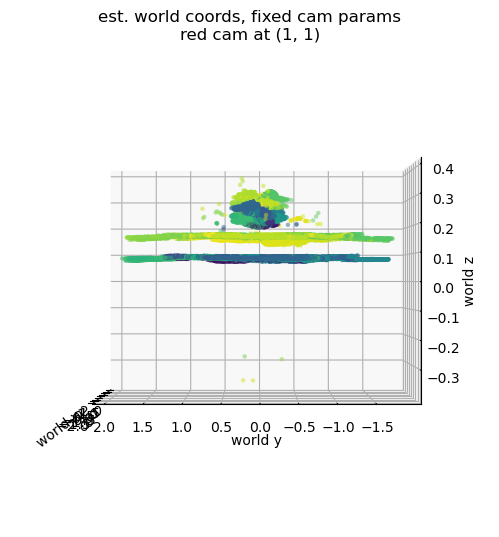

In [22]:
''' plot the estimated 3D coordinates '''
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 4))
ax = plt.axes([0, 0, .6, 1.2], projection='3d')

x_pts = sba.points3D[:, 0].copy()
y_pts = sba.points3D[:, 1].copy()
z_pts = sba.points3D[:, 2].copy()

n_pts = sba.points3D.shape[0]
colors = np.linspace(0, 1, n_pts)

ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors, cmap='viridis',
        alpha=0.5, lw=0, s=10)
# ax.set_xlim(-1, 1)
# ax.set_ylim(1, -1)
# ax.set_zlim(-1, 1)

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=180, elev=0)
ax.set_title(f'est. world coords, fixed cam params\nred cam at (1, 1)')

fig.savefig(f'{save_dir}cam_params_fixed_3d_elev0.png', dpi=600, bbox_inches='tight')
plt.show()

In [23]:
"""
Step 3:
-------
Given the updated 3d positions jointly optimize the camera parameters and 3d positions to minimize reconstruction errors.  
Use sba.bundleAdjust() if you want each camera to have separate intrinsics.
sba.bundleAdjust_sharedcam() uses shared intrinsics but with different image centroids used for radial distortion.
"""
sba.bundleAdjust_sharedcam()
# sba.bundleAdjust()
opt_cam_array = sba.cameraArray.copy()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7439e+05                                    1.82e+07    
       1              2         1.7263e+03      1.73e+05       1.07e+00       4.02e+05    
       2              3         1.6763e+03      5.00e+01       3.08e-01       1.84e+02    
       3              4         1.6762e+03      1.61e-02       2.10e-01       2.46e+02    
       4              5         1.6762e+03      2.12e-03       2.34e-02       3.94e+01    
       5              6         1.6762e+03      3.81e-04       3.45e-03       2.84e+01    
       6              7         1.6762e+03      9.71e-05       1.31e-03       1.75e+01    
       7              8         1.6762e+03      5.53e-05       5.38e-04       2.18e+01    
       8              9         1.6762e+03      5.43e-05       1.12e-03       1.59e+01    
       9             10         1.6762e+03      5.11e-05       4.63e-04       2.00e+01    

In [24]:
# display the updated camera params
x = PrettyTable()
x.field_names = cam_array_fields.copy()
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.09 | -1.51 |  -0.05  |  -0.22  |   2.33  |  1852.83   |    -0.2   |    0.15   | 936.69 | 475.93 |
|  0.87 | -2.02 |  1.51 |  -0.04  |  -0.21  |   2.25  |  1852.83   |    -0.2   |    0.15   | 952.32 | 497.79 |
|  1.71 | -0.75 |  0.55 |   0.03  |  -0.21  |   2.31  |  1852.83   |    -0.2   |    0.15   | 942.29 | 499.13 |
|  1.77 |  0.73 | -0.54 |  -0.12  |  -0.26  |   2.29  |  1852.83   |    -0.2   |    0.15   | 981.12 | 501.49 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


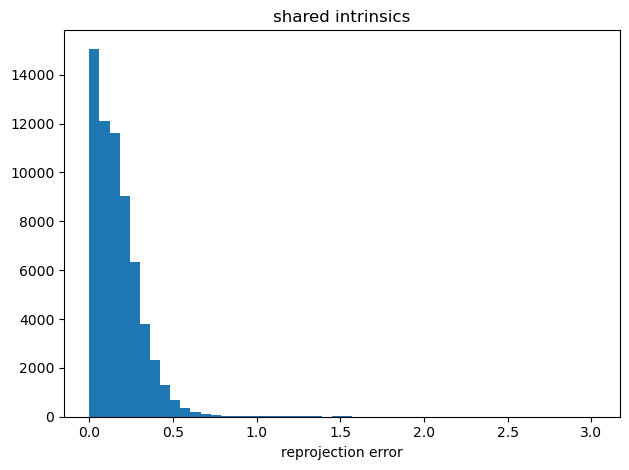

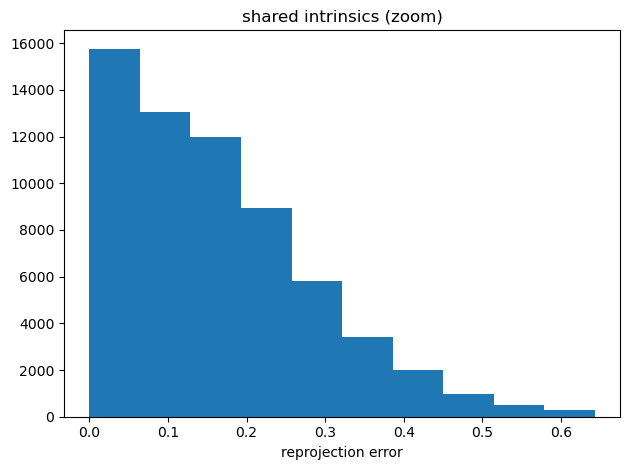

In [34]:
# get the reprojection error
r = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices]) - sba.points2D
r = np.sqrt(np.sum(r**2, axis=1))

# set a cut-off for high error
r_thresh = np.percentile(r, 99)

# plot the reprojection error
fig, ax = plt.subplots(1, 1)
ax.hist(r, bins=50)
ymin, ymax = ax.get_ylim()
# ax.vlines(r_thresh, ymin, ymax, colors='red', linestyles='dashed', label='99th percentile')
ax.set_xlabel('reprojection error')
ax.set_title('shared intrinsics')
plt.show()

# plot the reprojection error
fig, ax = plt.subplots(1, 1)
ax.hist(r[r < r_thresh], bins=10)
ymin, ymax = ax.get_ylim()
# ax.vlines(r_thresh, ymin, ymax, colors='red', linestyles='dashed', label='99th percentile')
ax.set_xlabel('reprojection error')
ax.set_title('shared intrinsics (zoom)')
plt.show()
fig.savefig(f'{save_dir}reproj_error_step3.png', dpi=600, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


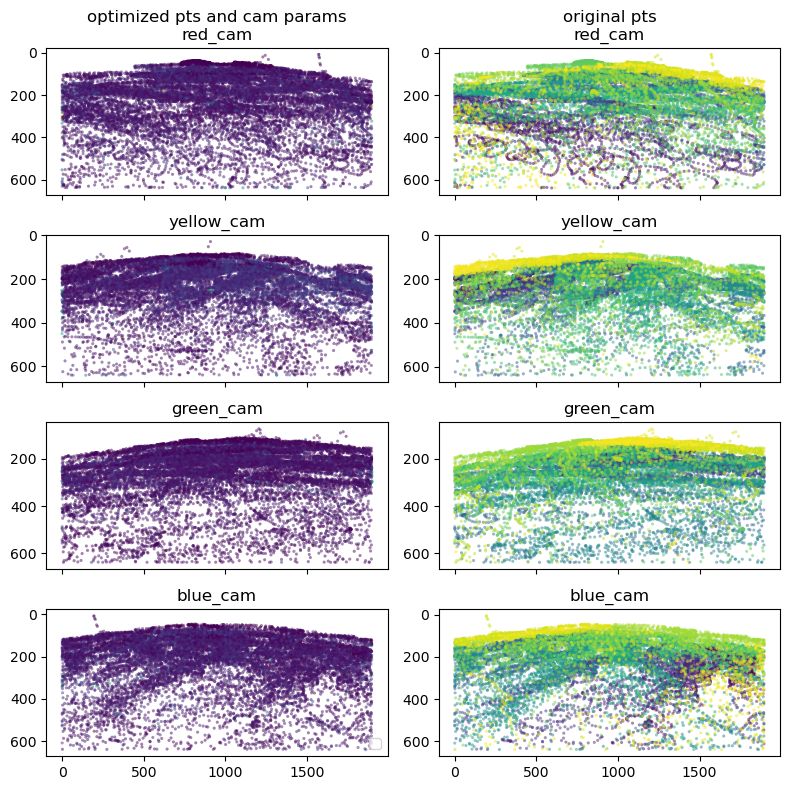

In [26]:
''' compare the reprojected 2D points to the original points '''
n_pts = sba.points3D.shape[0]

# get reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))
colors = np.linspace(0, 1, n_pts)

# reprojected points
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    cam_points = est_pts[ind2d].squeeze()
    axs[i, 0].scatter(cam_points[:, 0],\
                    cam_points[:, 1],\
                    s=5, lw=0, c=r[ind2d], alpha=0.5)
    
#     # highlight error
#     pts_error = r[ind2d]
#     axs[i, 0].scatter(cam_points[pts_error > r_thresh, 0],\
#                     cam_points[pts_error > r_thresh, 1],\
#                     facecolors='red', 
#                     s=6, lw=0, alpha=1, label=f'error > {np.round(r_thresh, 2)}')

    # fix y-axis orientation
    axs[i, 0].invert_yaxis()
    if i == 0:
        axs[i, 0].title.set_text(f'optimized pts and cam params\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')  
    if i == (n_cams-1):
        axs[i, 0].legend(loc='lower right')

# orginal points
for i in range(n_cams):
    # data params
    ind2d = camera_ind==i
    cam_points = sba.points2D[ind2d].squeeze()
    n_pts_cam = cam_points.shape[0]
    
    # plot the points
    colors = np.linspace(0, 1, n_pts_cam)
    axs[i, 1].scatter(cam_points[:, 0],
                   cam_points[:, 1],
                   s=5, lw=0, c=colors, alpha=0.5)
    axs[i, 1].invert_yaxis()
    if i == 0:
        axs[i, 1].title.set_text(f'original pts\n{cam_ids[i]}')
    else:
        axs[i, 1].title.set_text(f'{cam_ids[i]}')  
    
fig.savefig(f'{save_dir}cam_params_updated.png', dpi=600, bbox_inches='tight')
plt.show()

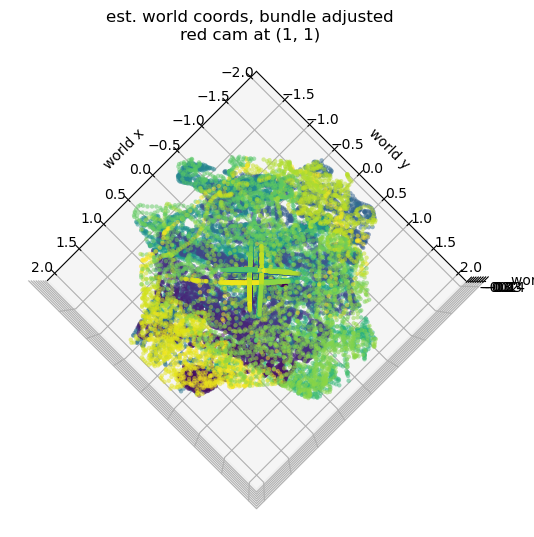

In [29]:
''' plot the estimated 3D coordinates '''
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 4))
ax = plt.axes([0, 0, .6, 1.2], projection='3d')

x_pts = sba.points3D[:, 0].copy()
y_pts = sba.points3D[:, 1].copy()
z_pts = sba.points3D[:, 2].copy()
colors = np.linspace(0, 1, n_pts)

ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors, cmap='viridis',
        alpha=0.5, lw=0, s=10)
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_zlim(-1, 1)

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=45, elev=90)
ax.set_title(f'est. world coords, bundle adjusted\nred cam at (1, 1)')

# fig.savefig(f'{save_dir}cam_params_updated_3d.png', dpi=600, bbox_inches='tight')
plt.show()

In [30]:
# save the 3D point locations
opt_3d_pts = sba.points3D

In [31]:
r = sba.project(pts_3d_known[known_pts_idx], sba.cameraArray[known_pts_camera_idx]) - pts_2d_known
r = np.sqrt(np.sum(r**2, axis=1))
n_pts = pts_3d_known.shape[0]

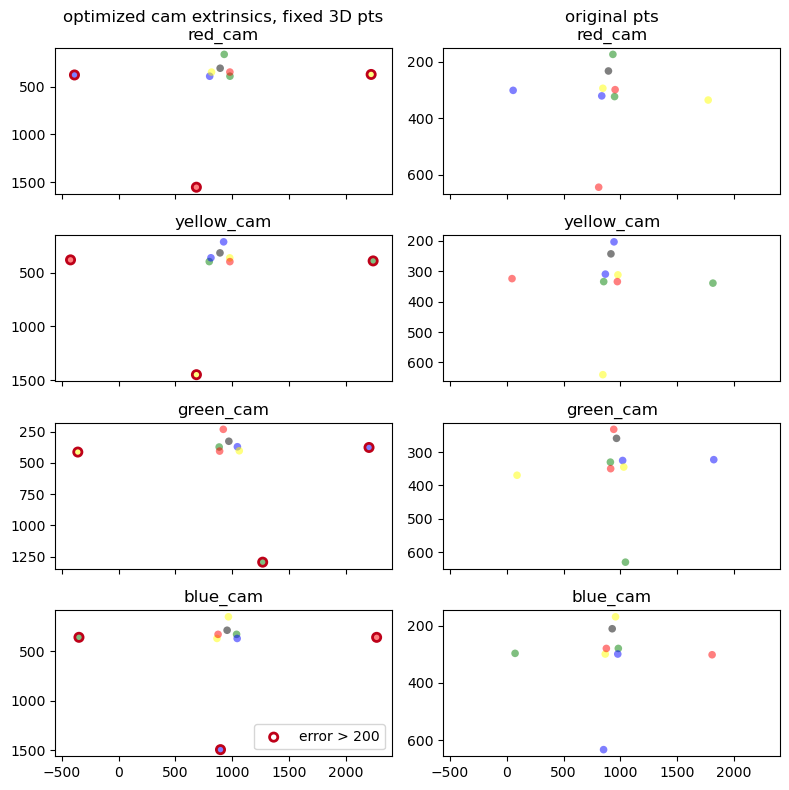

In [42]:
''' compare the reprojected 2D points to the original points - highlight points w/ high error '''
# get reprojected points
est_pts = sba.project(pts_3d_known[known_pts_idx], sba.cameraArray[known_pts_camera_idx])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))
r_thresh = 200

# reprojected points, optimized extrinsics
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    cam_points = est_pts[ind2d].squeeze()
    axs[i, 0].scatter(cam_points[:, 0],\
                    cam_points[:, 1],\
                    s=30, lw=0, c=colors, alpha=0.5)
    # highlight error
    pts_error = r[ind2d]
    axs[i, 0].scatter(cam_points[pts_error > r_thresh, 0],\
                    cam_points[pts_error > r_thresh, 1],\
                    facecolors='none', edgecolors='xkcd:scarlet', 
                    s=35, lw=2, alpha=1, label=f'error > {r_thresh}')
    
    if i == 0:
        axs[i, 0].title.set_text(f'optimized cam extrinsics, fixed 3D pts\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')   
    if i == (n_cams-1):
        axs[i, 0].legend(loc='lower right')
    axs[i, 0].invert_yaxis()

# orginal points
for i in range(n_cams):
    cam_idx = known_pts_camera_idx==i
    axs[i, 1].scatter(pts_2d_known[cam_idx, 0],
                      pts_2d_known[cam_idx, 1],
                      s=30, lw=0, c=colors, alpha=0.5)
    if i == 0:
        axs[i, 1].title.set_text(f'original pts\n{cam_ids[i]}')
    else:
        axs[i, 1].title.set_text(f'{cam_ids[i]}')
    axs[i, 1].invert_yaxis()
    
fig.savefig(f'{save_dir}known_3d_pts.png', dpi=600, bbox_inches='tight')
plt.show()

In [36]:
# get the residual
r = sba.project(pts_3d_known[known_pts_idx], sba.cameraArray[known_pts_camera_idx]) - pts_2d_known
r = np.sqrt(np.sum(r**2, axis=1))
n_pts = pts_3d_known.shape[0]

r_thresh = 600

# filter out the points with high error
trouble_pts = np.unique(known_pts_idx[r > r_thresh])
trouble_idx = np.zeros(known_pts_idx.shape[0])
for i in range(n_cams):
    for j in range(n_pts):
        ind = (i*n_pts) + j
        if known_pts_idx[ind] in trouble_pts:
            trouble_idx[ind] = 1
trouble_idx = trouble_idx.astype(bool)

# filter out troublesome points
filtered_pts = np.setdiff1d(np.arange(n_pts), trouble_pts)
pts_3d_known_filt = pts_3d_known[filtered_pts]
pts_2d_known_filt = pts_2d_known[~trouble_idx]
n_pts = pts_3d_known_filt.shape[0]

# create new indexing variables
filtered_camera_ind = np.zeros(shape=(n_pts*n_cams,), dtype=int)
filtered_point_ind = np.zeros(shape=(n_pts*n_cams,), dtype=int)
for i in range(n_cams):
    for j in range(n_pts):
        ind = (i*n_pts) + j
        filtered_camera_ind[ind] = i
        filtered_point_ind[ind] = j

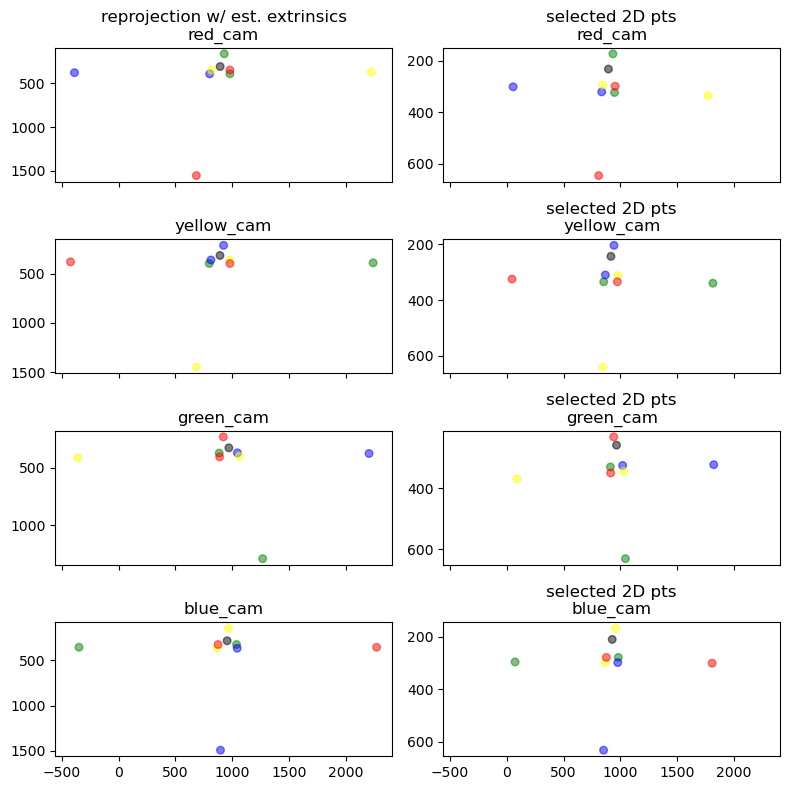

In [39]:
''' Re-scale/rotate extrinsics using known points '''
sba = pySBA.PySBA(opt_cam_array, pts_3d_known, pts_2d_known, 
                  known_pts_camera_idx, known_pts_idx)

# check the reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
colors = ['black', 'green', 'blue', 'yellow', 'red', 
          'green', 'blue', 'yellow', 'red']
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))

# selected points
for i in range(n_cams):
    cam_idx = known_pts_camera_idx==i
    axs[i, 1].scatter(pts_2d_known[cam_idx, 0],
                   pts_2d_known[cam_idx, 1],
                   c=colors, alpha=0.5, s=30)
    axs[i, 1].title.set_text(f'selected 2D pts\n{cam_ids[i]}')
    axs[i, 1].invert_yaxis()
    
# reprojected points, original extrinsics
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    axs[i, 0].scatter(est_pts[ind2d, 0],\
                    est_pts[ind2d, 1],\
                    s=30, c=colors, alpha=0.5)
    if i == 0:
        axs[i, 0].title.set_text(f'reprojection w/ est. extrinsics\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')    
    axs[i, 0].invert_yaxis()

        
plt.show()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2092e+06                                    4.07e+06    
       1              2         4.7123e+05      1.74e+06       9.99e-01       1.00e+06    
       2              3         1.4342e+04      4.57e+05       6.16e-01       1.44e+05    
       3              4         2.7620e+03      1.16e+04       1.20e-01       4.00e+03    
       4              5         2.7532e+03      8.81e+00       3.25e-03       3.93e+00    
       5              6         2.7532e+03      4.67e-05       1.85e-05       9.79e-02    
       6              7         2.7532e+03      4.41e-08       5.00e-07       7.26e-02    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 2.2092e+06, final cost 2.7532e+03, first-order optimality 7.26e-02.


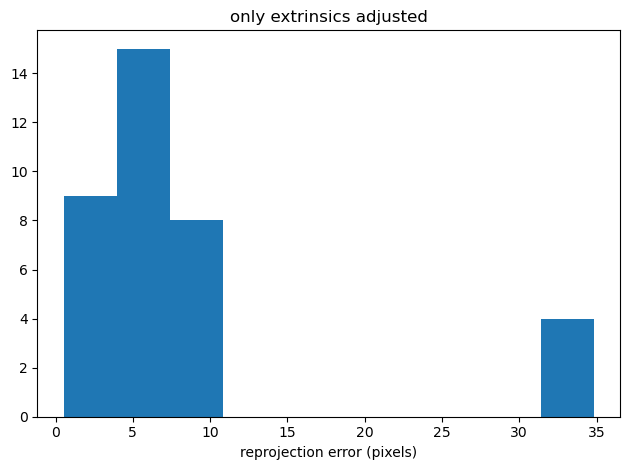

In [31]:
# optimize the camera extrinsics, holding the intrinsics fixed, using known 3D points
sba.bundleAdjust_just_extrinsics()

# plot the reprojection error
r = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices]) - sba.points2D
r = np.sqrt(np.sum(r**2, axis=1))

fig, ax = plt.subplots(1, 1)
ax.hist(r)
ax.set_xlabel('reprojection error (pixels)')
ax.set_title('only extrinsics adjusted')
plt.show()
fig.savefig(f'{save_dir}reproj_error_step4.png', dpi=600, bbox_inches='tight')

In [32]:
# display the updated camera params
x = PrettyTable()
x.field_names = cam_array_fields.copy()
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.81 |  2.07 | -1.52 |  -0.06  |  -0.21  |   2.31  |  1852.96   |    -0.2   |    0.16   | 948.27 | 475.51 |
|  0.87 | -2.01 |  1.52 |  -0.03  |  -0.22  |   2.24  |  1852.96   |    -0.2   |    0.16   | 940.73 | 497.63 |
|  1.71 | -0.76 |  0.55 |   0.01  |  -0.21  |   2.29  |  1852.96   |    -0.2   |    0.16   | 956.66 | 499.41 |
|  1.77 |  0.76 | -0.55 |  -0.05  |  -0.27  |   2.28  |  1852.96   |    -0.2   |    0.16   | 968.16 | 503.87 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


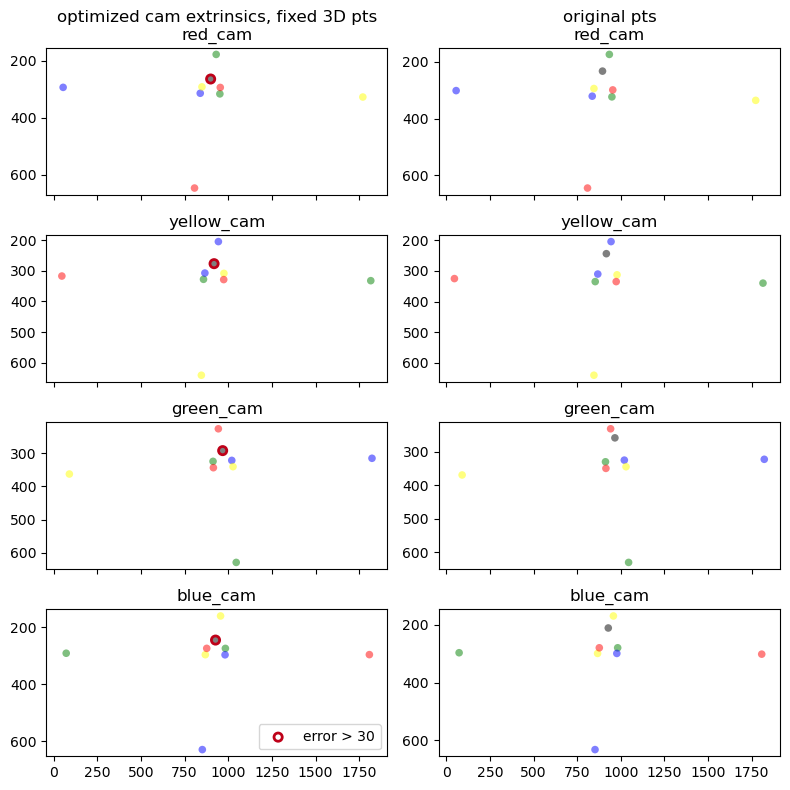

In [34]:
# get reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))
r_thresh = 30

# reprojected points, optimized extrinsics
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    cam_points = est_pts[ind2d].squeeze()
    axs[i, 0].scatter(cam_points[:, 0],\
                    cam_points[:, 1],\
                    s=30, lw=0, c=colors, alpha=0.5)
    # highlight error
    pts_error = r[ind2d]
    axs[i, 0].scatter(cam_points[pts_error > r_thresh, 0],\
                    cam_points[pts_error > r_thresh, 1],\
                    facecolors='none', edgecolors='xkcd:scarlet', 
                    s=35, lw=2, alpha=1, label=f'error > {r_thresh}')
    
    if i == 0:
        axs[i, 0].title.set_text(f'optimized cam extrinsics, fixed 3D pts\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')   
    if i == (n_cams-1):
        axs[i, 0].legend(loc='lower right')
    axs[i, 0].invert_yaxis()

# orginal points
for i in range(n_cams):
    cam_idx = known_pts_camera_idx==i
    axs[i, 1].scatter(pts_2d_known[cam_idx, 0],
                      pts_2d_known[cam_idx, 1],
                      s=30, lw=0, c=colors, alpha=0.5)
    if i == 0:
        axs[i, 1].title.set_text(f'original pts\n{cam_ids[i]}')
    else:
        axs[i, 1].title.set_text(f'{cam_ids[i]}')
    axs[i, 1].invert_yaxis()
    
plt.show()

In [35]:
# save the updated camera array
cam_array_new = sba.cameraArray

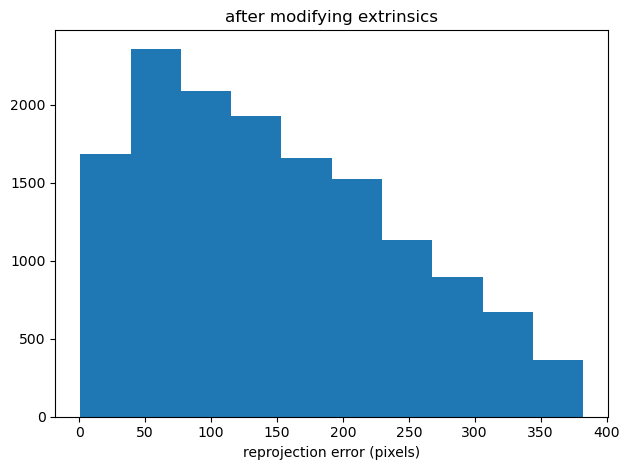

In [39]:
''' check the error on the laser pointer points '''
# get the reprojection error
r = sba.project(opt_3d_pts[point_ind], cam_array_new[camera_ind]) - points_2d
r = np.sqrt(np.sum(r**2, axis=1))

# set a cut-off for high error
r_thresh = np.percentile(r, 99)

# plot the reprojection error
fig, ax = plt.subplots(1, 1)
ax.hist(r[r < r_thresh], bins=10)
ymin, ymax = ax.get_ylim()
# ax.vlines(r_thresh, ymin, ymax, colors='red', linestyles='dashed', label='99th percentile')
ax.set_xlabel('reprojection error (pixels)')
ax.set_title('after modifying extrinsics')
plt.show()
fig.savefig(f'{save_dir}reproj_error_step4b.png', dpi=600, bbox_inches='tight')

In [53]:
r_thresh = np.percentile(r, 99)
n_pts = np.max(point_ind) + 1
# point_ind = filtered_point_ind

In [54]:
n_pts

24756

In [55]:
''' optionally eliminate points w/ high reprojection error '''
# indices for points with high reprojection error
trouble_pts = np.unique(point_ind[r > r_thresh])
trouble_idx = np.zeros(point_ind.shape[0])
for i in range(n_cams):
    for j in range(n_pts):
        ind = (i*n_pts) + j
        if point_ind[ind] in trouble_pts:
            trouble_idx[ind] = 1
trouble_idx = trouble_idx.astype(bool)

# filter out troublesome points
filtered_pts = np.setdiff1d(np.arange(n_pts), trouble_pts)
filtered_pts_3d = sba.points3D[filtered_pts]
filtered_pts_2d = sba.points2D[~trouble_idx]
n_pts = filtered_pts_3d.shape[0]

print(f'filtered out {np.sum(trouble_idx)} high error points; {n_pts} remain')

IndexError: index 63352 is out of bounds for axis 0 with size 63352

In [41]:
# create new indexing variables
filtered_camera_ind = np.zeros(shape=(n_pts*n_cams,), dtype=int)
filtered_point_ind = np.zeros(shape=(n_pts*n_cams,), dtype=int)
for i in range(n_cams):
    for j in range(n_pts):
        ind = (i*n_pts) + j
        filtered_camera_ind[ind] = i
        filtered_point_ind[ind] = j

In [42]:
cam_array_new = sba.cameraArray
sba = pySBA.PySBA(cam_array_new, filtered_pts_3d, filtered_pts_2d, 
                  filtered_camera_ind, filtered_point_ind)

# display the initial camera params
x = PrettyTable()
x.field_names = cam_array_fields
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.84 |  2.08 | -1.51 |  -0.04  |  -0.09  |   1.48  |  1852.96   |    -0.2   |    0.16   | 948.27 | 475.51 |
|  0.85 | -2.01 |  1.53 |  -0.04  |  -0.09  |   1.45  |  1852.96   |    -0.2   |    0.16   | 940.73 | 497.63 |
|  1.71 | -0.76 |  0.58 |   0.01  |  -0.09  |   1.51  |  1852.96   |    -0.2   |    0.16   | 956.66 | 499.41 |
|  1.79 |  0.75 | -0.53 |  -0.01  |  -0.13  |   1.48  |  1852.96   |    -0.2   |    0.16   | 968.16 | 503.87 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


In [43]:
"""
Optimize for the 3d positions and camera parameters (w/ filtered points)
"""
sba.bundleAdjust_sharedcam()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7688e+02                                    2.00e+04    
       1              2         2.7537e+02      1.51e+00       9.63e-01       2.25e+02    
       2              3         2.7537e+02      7.60e-03       5.57e-01       1.75e+02    
       3              4         2.7536e+02      2.32e-03       1.22e-01       2.40e+01    
       4              5         2.7536e+02      2.83e-05       1.95e-03       1.12e+01    
       5              6         2.7536e+02      1.52e-05       1.10e-03       7.94e+00    
       6              7         2.7536e+02      6.18e-06       4.26e-04       4.01e+00    
       7              8         2.7536e+02      6.18e-06       7.08e-04       6.58e+00    
       8              9         2.7536e+02      5.55e-06       4.06e-04       3.33e+00    
       9             10         2.7536e+02      5.45e-06       7.00e-04       6.16e+00    

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-3.518e-01 -4.847e-03 ...  1.845e-01 -4.194e-05]
           x: [ 1.853e+03 -2.028e-01 ... -7.112e-02  7.163e-02]
        cost: 275.36345901475
         jac:   (0, 0)	0.09824347154739987
                (0, 1)	7.076110984665163
                (0, 2)	0.2729453668479284
                (0, 3)	-266.46455800246196
                (0, 4)	347.12897587758783
                (0, 5)	-221.0262919823346
                (0, 6)	869.6265786532264
                (0, 7)	5.6183981688271105
                (0, 8)	-85.13461705272753
                (0, 27)	1.0
                (0, 28)	0.0
                (0, 35)	-568.8889388138891
                (0, 36)	663.0733917444464
                (0, 37)	15.129710930249384
                (1, 0)	-0.16834041958572193
                (1, 1)	-12.12493282199336
                (1, 2)	-0.4676925208056215
                (1, 3)	-282.3776593019912
                (

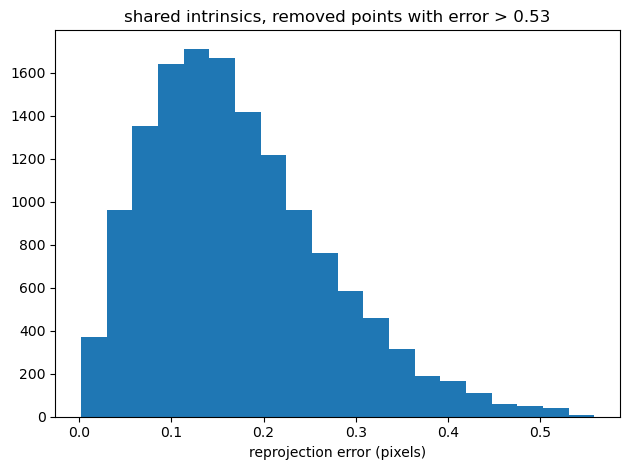

In [45]:
# plot the reprojection error
r = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices]) - sba.points2D
r = np.sqrt(np.sum(r**2, axis=1))
plt.hist(r, bins=20)
plt.xlabel('reprojection error (pixels)')
plt.title(f'shared intrinsics, removed points with error > {np.round(r_thresh, 2)}')
plt.show()

In [46]:
# display the camera params
x = PrettyTable()
x.field_names = cam_array_fields
for row in sba.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.84 |  2.08 | -1.51 |  -0.04  |  -0.09  |   1.48  |  1853.13   |    -0.2   |    0.16   | 948.13 | 475.35 |
|  0.85 | -2.01 |  1.53 |  -0.04  |  -0.09  |   1.45  |  1853.13   |    -0.2   |    0.16   | 941.06 | 497.22 |
|  1.71 | -0.76 |  0.58 |   0.01  |  -0.09  |   1.51  |  1853.13   |    -0.2   |    0.16   | 955.95 | 499.34 |
|  1.79 |  0.75 | -0.53 |  -0.01  |  -0.13  |   1.48  |  1853.13   |    -0.2   |    0.16   | 969.07 | 503.61 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


In [48]:
"""
Rescale translation vector to a standard value
"""
targScale = 1.5
thisScale = np.mean(np.sqrt(np.sum(opt_cam_array[:,3:6]**2, axis=1)))
opt_cam_array[:, 3:6] = opt_cam_array[:, 3:6] * (targScale/thisScale)
sba_scaled = pySBA.PySBA(opt_cam_array, sba.points3D, sba.points2D,\
                            sba.cameraIndices, sba.point2DIndices)
sba_scaled.bundleAdjust_nocam()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8958e+05                                    5.74e+04    
       1              2         2.7819e+02      1.89e+05       3.02e-01       2.61e+02    
       2              3         2.7688e+02      1.31e+00       6.56e-04       2.36e-02    
       3              4         2.7688e+02      9.22e-09       7.63e-08       4.47e-03    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 4, initial cost 1.8958e+05, final cost 2.7688e+02, first-order optimality 4.47e-03.


     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [-3.536e-01 -2.268e-02 ...  1.853e-01  3.185e-03]
           x: [-6.580e-01 -3.157e-01 ... -7.171e-02  7.247e-02]
        cost: 276.88052808198216
         jac:   (0, 0)	-563.1607040841161
                (0, 1)	656.3155494511773
                (0, 2)	14.965708280585774
                (1, 0)	89.44047791434251
                (1, 1)	92.20222290142623
                (1, 2)	-857.1249245247454
                (2, 3)	-567.3906377738649
                (2, 4)	654.0706736012168
                (2, 5)	13.788125938824617
                (3, 3)	89.838475059134
                (3, 4)	92.16257732477888
                (3, 5)	-858.2365914198859
                (4, 6)	-572.1364931226813
                (4, 7)	653.7850903608536
                (4, 8)	12.878139737851651
                (5, 6)	90.56810547456566
                (5, 7)	92.53836865165793
                (5, 8)	-86

In [49]:
# display the updated camera params
x = PrettyTable()
x.field_names = cam_array_fields.copy()
for row in sba_scaled.cameraArray:
    x.add_row(np.round(row, 2))
print(x)

+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
| rot_1 | rot_2 | rot_3 | trans_1 | trans_2 | trans_3 | focal dist | distort_1 | distort_2 |  pt_x  |  pt_y  |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+
|  0.84 |  2.08 | -1.51 |  -0.04  |  -0.09  |   1.5   |  1852.96   |    -0.2   |    0.16   | 948.27 | 475.51 |
|  0.85 | -2.01 |  1.53 |  -0.04  |  -0.09  |   1.47  |  1852.96   |    -0.2   |    0.16   | 940.73 | 497.63 |
|  1.71 | -0.76 |  0.58 |   0.01  |  -0.09  |   1.53  |  1852.96   |    -0.2   |    0.16   | 956.66 | 499.41 |
|  1.79 |  0.75 | -0.53 |  -0.01  |  -0.13  |   1.49  |  1852.96   |    -0.2   |    0.16   | 968.16 | 503.87 |
+-------+-------+-------+---------+---------+---------+------------+-----------+-----------+--------+--------+


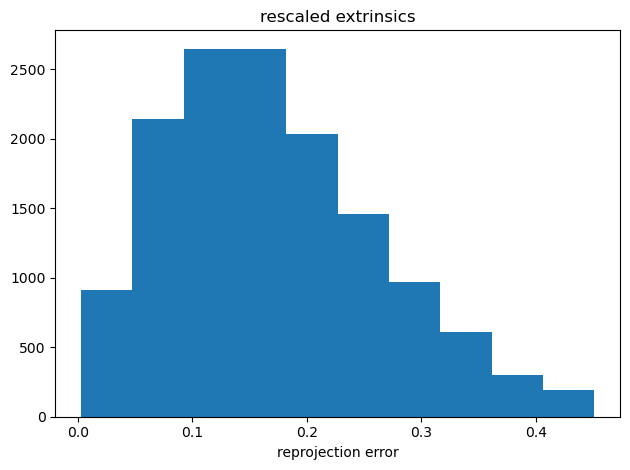

In [50]:
# plot the reprojection error
r = sba_scaled.project(sba_scaled.points3D[sba_scaled.point2DIndices], sba_scaled.cameraArray[sba_scaled.cameraIndices]) - sba_scaled.points2D
r = np.sqrt(np.sum(r**2, axis=1))
plt.hist(r[r < np.percentile(r, 99)])
plt.xlabel('reprojection error')
plt.title('rescaled extrinsics')
plt.show()

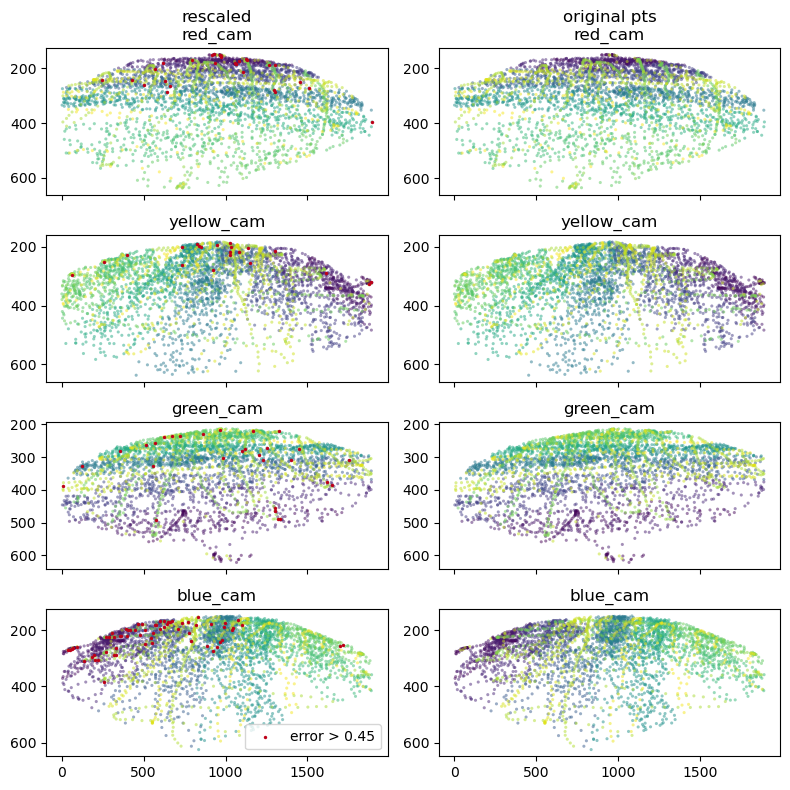

In [51]:
''' compare the reprojected 2D points to the original points '''
# get reprojected points
est_pts = sba.project(sba.points3D[sba.point2DIndices], sba.cameraArray[sba.cameraIndices])

# fig params
fig, axs = plt.subplots(n_cams, 2, sharex=True, figsize=(8, 8))
colors = np.linspace(0, 1, n_pts)
r_thresh = np.round(np.percentile(r, 99), 2)

# reprojected points
for i in range(n_cams):
    ind2d = sba.cameraIndices==i
    cam_points = est_pts[ind2d].squeeze()
    axs[i, 0].scatter(cam_points[:, 0],\
                    cam_points[:, 1],\
                    s=5, lw=0, c=colors, alpha=0.5)
    
    # highlight error
    pts_error = r[ind2d]
    axs[i, 0].scatter(cam_points[pts_error > r_thresh, 0],\
                    cam_points[pts_error > r_thresh, 1],\
                    facecolors='xkcd:scarlet', 
                    s=6, lw=0, alpha=1, label=f'error > {r_thresh}')

    axs[i, 0].invert_yaxis()
    if i == 0:
        axs[i, 0].title.set_text(f'rescaled\n{cam_ids[i]}')
    else:
        axs[i, 0].title.set_text(f'{cam_ids[i]}')  
    if i == (n_cams-1):
        axs[i, 0].legend(loc='lower right')

# orginal points
for i in range(n_cams):
    ind2d = sba.cameraIndices==i    
    axs[i, 1].scatter(sba.points2D[ind2d, 0], 
                      sba.points2D[ind2d, 1],
                      s=5, lw=0, c=colors, alpha=0.5)
    axs[i, 1].invert_yaxis()
    if i == 0:
        axs[i, 1].title.set_text(f'original pts\n{cam_ids[i]}')
    else:
        axs[i, 1].title.set_text(f'{cam_ids[i]}')  
    
fig.savefig(f'{save_dir}rescaled.png', dpi=600, bbox_inches='tight')
plt.show()

C:\Users\ilow1\AppData\Local\Temp\ipykernel_15248\1411008711.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{save_dir}rescaled_3d.png', dpi=600, bbox_inches='tight')


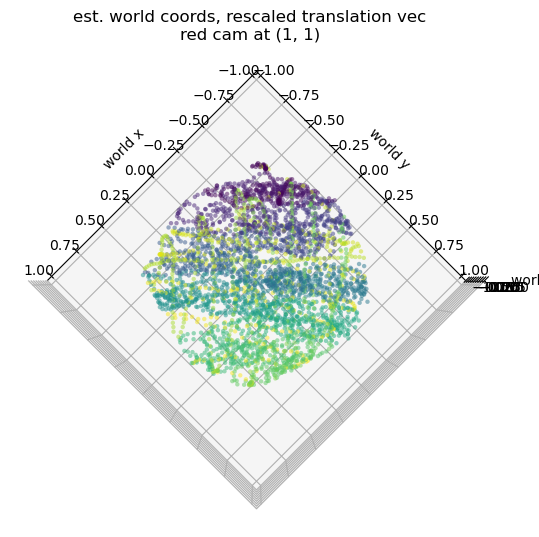

In [53]:
''' plot the estimated 3D coordinates '''
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 4))
ax = plt.axes([0, 0, .6, 1.2], projection='3d')

x_pts = sba.points3D[:, 0].copy()
y_pts = sba.points3D[:, 1].copy()
z_pts = sba.points3D[:, 2].copy()
colors = np.linspace(0, 1, n_pts)

ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors, cmap='viridis',
        alpha=0.5, lw=0, s=10)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(-1.0, 1.0)

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=45, elev=90)
ax.set_title(f'est. world coords, rescaled translation vec\nred cam at (1, 1)')

fig.savefig(f'{save_dir}rescaled_3d.png', dpi=600, bbox_inches='tight')
plt.show()

In [35]:
"""
Save the optimized camera array and 3D point locations
"""
# 3D point locations
opt_3d_pts = sba.points3D
opt_3d_pts_file = f"{tmp_local_root}/calibration_files/{img_date}_opt_3d_points.npy"
np.save(opt_3d_pts_file, opt_3d_pts)

# optimized camera array
opt_array_file = f"{tmp_local_root}/calibration_files/{img_date}_opt_cam_array_zeroes_init.npy"
np.save(opt_array_file, opt_cam_array)

# also save the camera array for use in matlab
from scipy.io import savemat
cam_dict = {"optCamArray":opt_cam_array}
arena_align_root = "C:/Users/ilow1/Documents/code/il_rig_control/camera_alignment/"
savemat(f"{arena_align_root}{img_date}_opt_cam_array_laser_pts.mat", cam_dict)